In [51]:
from pathlib import Path
from tempfile import TemporaryDirectory

import matplotlib.pyplot as plt
import numpy as np

import suite2p
from suite2p import run_s2p, default_ops
ops = default_ops() # populates ops with the default options
import sys
sys.path.insert(0, 'C:/Users/lan/Documents/repos/suite2p') # option to import from github folder

import matplotlib as mpl
mpl.rcParams.update({
    'axes.spines.left': False,
    'axes.spines.bottom': False,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'legend.frameon': False,
    'figure.subplot.wspace': .01,
    'figure.subplot.hspace': .01,
    'figure.figsize': (18, 13),
    'ytick.major.left': False,
})
jet = mpl.cm.get_cmap('jet')
jet.set_bad(color='k')

C:\Users\lan\anaconda3\envs\suite2p\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("jet"))


In [ ]:
# add input date mouse run_num. modify below to match

In [52]:
# adjust ROI detection to ensure inclusion of cells responsive to our stim?
# ops['preclassify'] = 0.0 # should impose ROI size requirement afterwards

In [55]:
'''spatial_scale: (int, default: 0), what the optimal scale of the recording is in pixels. if set to 0, then the algorithm determines it automatically (recommend this on the first try). If it seems off, set it yourself to the following values: 1 (=6 pixels), 2 (=12 pixels), 3 (=24 pixels), or 4 (=48 pixels).'''

# ops['save_path0'] = "//duhs-user-nc1.dhe.duke.edu/dusom_glickfeldlab/All_Staff/home/lan/Analysis/2P/200803_i1322/200803_i1322_runs-002/suite2p_ops_20210122" 
# cannot find result files if save_path is set to dusom
ops['save_path0'] = "D:/Lan_temp/suite2p/plane0_i1324_200728_003"
ops['fast_disk'] = ops['save_path0']

ops['tau'] = (1.25 + 1.5) / 2 # timescale of sensor (in seconds), used for deconvolution kernel. 1.25-1.5 for GCaMP6s
ops['fs'] = 30 # sampling rate
ops['aspect'] = 796 / 264 # aspect ratio for visualization in GUI
ops['sparse_mode'] = True
ops['threshold_scaling'] = 0.7 # how much the ROIs have to stand out from the noise to be detected
ops['batch_size'] = 1200 # takes RAM. keep at 1300 acc. to 2021-01-27 (max 98% CPU)

ops

{'suite2p_version': '0.9.3.dev9+g17501ef',
 'look_one_level_down': False,
 'fast_disk': 'D:/Lan_temp/suite2p/plane0_i1324_200728_003',
 'delete_bin': False,
 'mesoscan': False,
 'bruker': False,
 'h5py': [],
 'h5py_key': 'data',
 'save_path0': 'D:/Lan_temp/suite2p/plane0_i1324_200728_003',
 'save_folder': [],
 'subfolders': [],
 'move_bin': False,
 'nplanes': 1,
 'nchannels': 1,
 'functional_chan': 1,
 'tau': 1.375,
 'fs': 30,
 'force_sktiff': False,
 'frames_include': -1,
 'multiplane_parallel': False,
 'preclassify': 0.0,
 'save_mat': False,
 'save_NWB': False,
 'combined': True,
 'aspect': 3.015151515151515,
 'do_bidiphase': False,
 'bidiphase': 0,
 'bidi_corrected': False,
 'do_registration': 1,
 'two_step_registration': False,
 'keep_movie_raw': False,
 'nimg_init': 300,
 'batch_size': 1300,
 'maxregshift': 0.1,
 'align_by_chan': 1,
 'reg_tif': False,
 'reg_tif_chan2': False,
 'subpixel': 10,
 'smooth_sigma_time': 0,
 'smooth_sigma': 1.15,
 'th_badframes': 1.0,
 'pad_fft': False,


In [54]:
cd //duhs-user-nc1.dhe.duke.edu/dusom_glickfeldlab/All_Staff/home/lan/Data/2P_images/i1324/200728/003

\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\i1324\200728\003


In [57]:
# find h5py keys
import h5py
f = h5py.File('003_000_000.h5', 'r')
[key for key in f.keys()]

['data']

In [58]:
ls

 Volume in drive Y is dusom_glickfeldlab
 Volume Serial Number is 009A-9A03

 Directory of Y:\All_Staff\home\lan\Data\2P_images\i1324\200728\003

01/27/2021  03:03 PM    <DIR>          .
10/02/2020  10:38 AM    <DIR>          ..
07/28/2020  12:53 PM       266,744,000 003_000_000.ephys
01/27/2021  03:27 PM    42,028,832,504 003_000_000.h5
07/28/2020  12:55 PM             1,146 003_000_000.mat
07/28/2020  12:53 PM    42,028,800,000 003_000_000.sbx
07/28/2020  12:55 PM     1,420,278,331 003_000_000_eye.mat
07/28/2020  12:53 PM           922,445 003_000_000_realtime.mat
               6 File(s) 85,745,578,426 bytes
               2 Dir(s)  110,142,661,754,880 bytes free


In [60]:
# provide an h5 path in 'h5py' or a tiff path in 'data_path'
# db overwrites any ops (allows for experiment specific settings)
db = {
      'h5py': '//duhs-user-nc1.dhe.duke.edu/dusom_glickfeldlab/All_Staff/home/lan/Data/2P_images/i1324/200728/003/003_000_000.h5', # a single h5 file path
      'h5py_key': ['data'],
      'look_one_level_down': False, # whether to look in ALL subfolders when searching for tiffs
      'data_path': [], # a list of folders with tiffs (or folder of folders with tiffs if look_one_level_down is True, or subfolders is not empty)
                                            
#       'subfolders': [], # choose subfolders of 'data_path' to look in (optional)
#       'fast_disk': 'C:/BIN', # string which specifies where the binary file will be stored (should be an SSD)
    }

opsEnd = run_s2p(ops=ops, db=db)

{'h5py': '//duhs-user-nc1.dhe.duke.edu/dusom_glickfeldlab/All_Staff/home/lan/Data/2P_images/i1324/200728/003/003_000_000.h5', 'h5py_key': ['data'], 'look_one_level_down': False, 'data_path': []}
h5
time 1194.88 sec. Wrote 99999 frames per binary for 1 planes
>>>>>>>>>>>>>>>>>>>>> PLANE 0 <<<<<<<<<<<<<<<<<<<<<<
NOTE: not registered / registration forced with ops['do_registration']>1
      (no previous offsets to delete)
----------- REGISTRATION
registering 99999 frames
Reference frame, 105.17 sec.
Registered 5200/99999 in 732.60s
Registered 10400/99999 in 1518.26s
Registered 15600/99999 in 2235.26s
Registered 20800/99999 in 3006.89s
Registered 26000/99999 in 3609.91s
Registered 31200/99999 in 4102.12s
Registered 36400/99999 in 4415.15s
Registered 41600/99999 in 4741.16s
Registered 46800/99999 in 5069.24s
Registered 52000/99999 in 5398.38s
Registered 57200/99999 in 5711.99s
Registered 62400/99999 in 6028.88s
Registered 67600/99999 in 6334.98s
Registered 72800/99999 in 6651.49s
Registered

In [63]:
10981.64/3600

3.0504555555555553

In [64]:
opsEnd

{'suite2p_version': '0.9.3.dev9+g17501ef',
 'look_one_level_down': False,
 'fast_disk': 'D:/Lan_temp/suite2p/plane0_i1324_200728_003\\suite2p\\plane0',
 'delete_bin': False,
 'mesoscan': False,
 'bruker': False,
 'h5py': '//duhs-user-nc1.dhe.duke.edu/dusom_glickfeldlab/All_Staff/home/lan/Data/2P_images/i1324/200728/003/003_000_000.h5',
 'h5py_key': ['data'],
 'save_path0': 'D:/Lan_temp/suite2p/plane0_i1324_200728_003',
 'save_folder': 'suite2p',
 'subfolders': [],
 'move_bin': False,
 'nplanes': 1,
 'nchannels': 1,
 'functional_chan': 1,
 'tau': 1.375,
 'fs': 30,
 'force_sktiff': False,
 'frames_include': -1,
 'multiplane_parallel': False,
 'preclassify': 0.0,
 'save_mat': False,
 'save_NWB': False,
 'combined': True,
 'aspect': 3.015151515151515,
 'do_bidiphase': False,
 'bidiphase': 0,
 'bidi_corrected': True,
 'do_registration': 1,
 'two_step_registration': False,
 'keep_movie_raw': False,
 'nimg_init': 300,
 'batch_size': 1300,
 'maxregshift': 0.1,
 'align_by_chan': 1,
 'reg_tif': 

In [65]:
print(set(opsEnd.keys()).difference(ops.keys()))

{'input_format', 'Vcorr', 'date_proc', 'max_proj', 'regDX', 'Lyc', 'data_path', 'xoff', 'yblock', 'nframes', 'Ly', 'xrange', 'spatscale_pix', 'regPC', 'Vmax', 'Lx', 'NRsm', 'ops_path', 'yrange', 'corrXY', 'tPC', 'Vsplit', 'filelist', 'ihop', 'badframes', 'nframes_per_folder', 'h5list', 'nblocks', 'corrXY1', 'yoff1', 'save_path', 'refImg', 'xblock', 'xoff1', 'meanImgE', 'Lxc', 'timing', 'reg_file', 'meanImg', 'yoff', 'Vmap'}


In [67]:
opsEnd['save_path'] = 'D:\Lan_temp\suite2p\plane0_i1324_200728_003'
list(Path(opsEnd['save_path']).iterdir())

[WindowsPath('D:/Lan_temp/suite2p/plane0_i1324_200728_003/F.npy'),
 WindowsPath('D:/Lan_temp/suite2p/plane0_i1324_200728_003/Fneu.npy'),
 WindowsPath('D:/Lan_temp/suite2p/plane0_i1324_200728_003/iscell.npy'),
 WindowsPath('D:/Lan_temp/suite2p/plane0_i1324_200728_003/ops.npy'),
 WindowsPath('D:/Lan_temp/suite2p/plane0_i1324_200728_003/spks.npy'),
 WindowsPath('D:/Lan_temp/suite2p/plane0_i1324_200728_003/stat.npy'),
 WindowsPath('D:/Lan_temp/suite2p/plane0_i1324_200728_003/suite2p')]

In [68]:
output_op_file = np.load(Path(opsEnd['save_path']).joinpath('ops.npy'), allow_pickle=True).item()
output_op_file.keys() == opsEnd.keys()

True

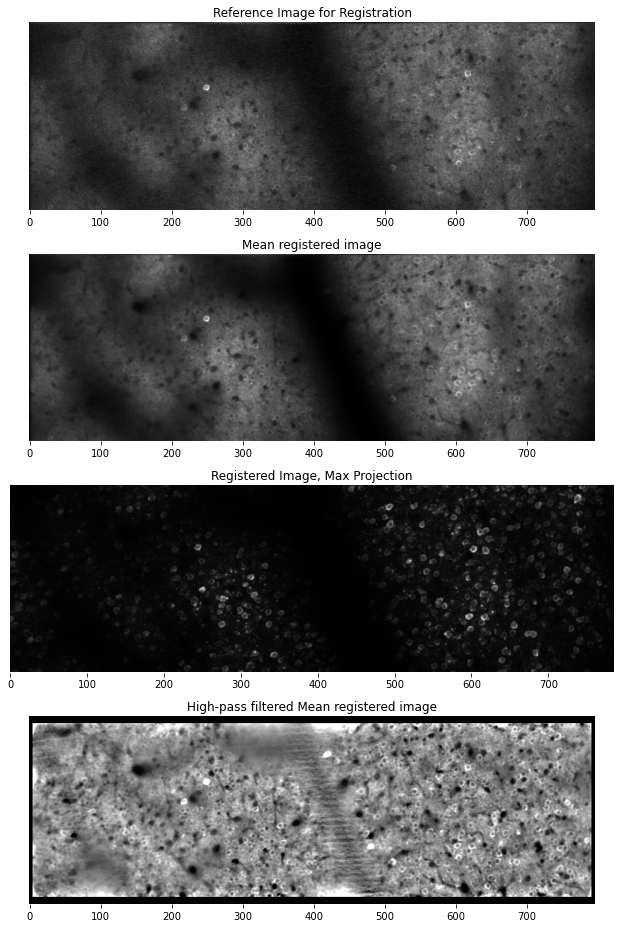

In [69]:
output_op = opsEnd

plt.subplot(4, 1, 1)
plt.imshow(output_op['refImg'], cmap='gray', )
plt.title("Reference Image for Registration");

plt.subplot(4, 1, 3)
plt.imshow(output_op['max_proj'], cmap='gray')
plt.title("Registered Image, Max Projection");

plt.subplot(4, 1, 2)
plt.imshow(output_op['meanImg'], cmap='gray')
plt.title("Mean registered image")

plt.subplot(4, 1, 4)
plt.imshow(output_op['meanImgE'], cmap='gray')
plt.title("High-pass filtered Mean registered image");

plt.tight_layout()

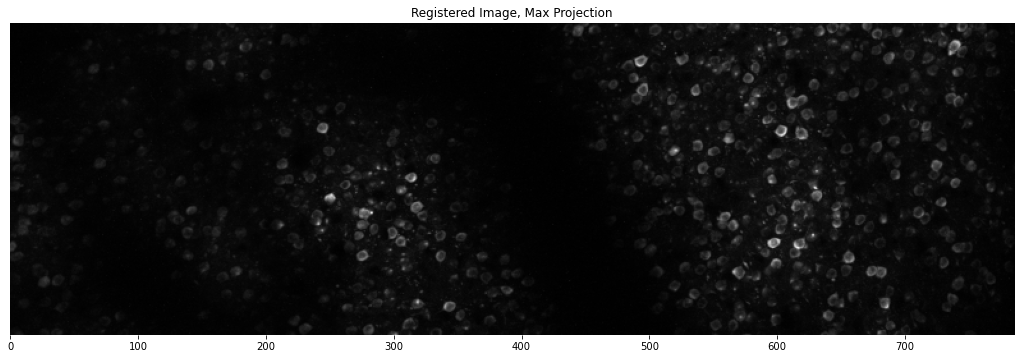

In [70]:
plt.imshow(output_op['max_proj'], cmap='gray')
plt.title("Registered Image, Max Projection");

In [71]:
stats_file = Path(output_op['save_path']).joinpath('stat.npy')
iscell = np.load(Path(output_op['save_path']).joinpath('iscell.npy'), allow_pickle=True)[:, 0].astype(bool)
stats = np.load(stats_file, allow_pickle=True)
stats.shape, iscell.shape # adjusted ops increased cell num from 2867 to 4349

((2685,), (2685,))

C:\Users\lan\anaconda3\envs\suite2p\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: All-NaN slice encountered
  if __name__ == '__main__':
C:\Users\lan\anaconda3\envs\suite2p\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: All-NaN slice encountered
  del sys.path[0]
C:\Users\lan\anaconda3\envs\suite2p\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: All-NaN slice encountered


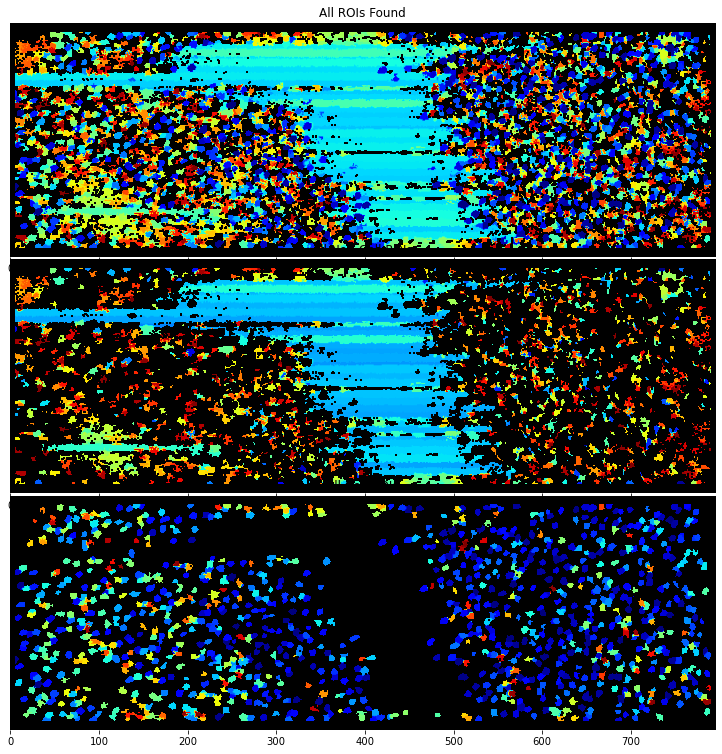

In [72]:
im = suite2p.ROI.stats_dicts_to_3d_array(stats, Ly=output_op['Ly'], Lx=output_op['Lx'], label_id=True)
im[im == 0] = np.nan

# plt.subplot(1, 4, 1)
# plt.imshow(output_op['max_proj'], cmap='gray')
# plt.title("Registered Image, Max Projection")

plt.subplot(3,1,1)
plt.imshow(np.nanmax(im, axis=0), cmap='jet')
plt.title("All ROIs Found")

plt.subplot(3,1,2)
plt.imshow(np.nanmax(im[~iscell], axis=0, ), cmap='jet')
plt.title("All Non-Cell ROIs")

plt.subplot(3,1,3)
plt.imshow(np.nanmax(im[iscell], axis=0), cmap='jet')
plt.title("All Cell ROIs");

C:\Users\lan\anaconda3\envs\suite2p\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: All-NaN slice encountered
  """Entry point for launching an IPython kernel.


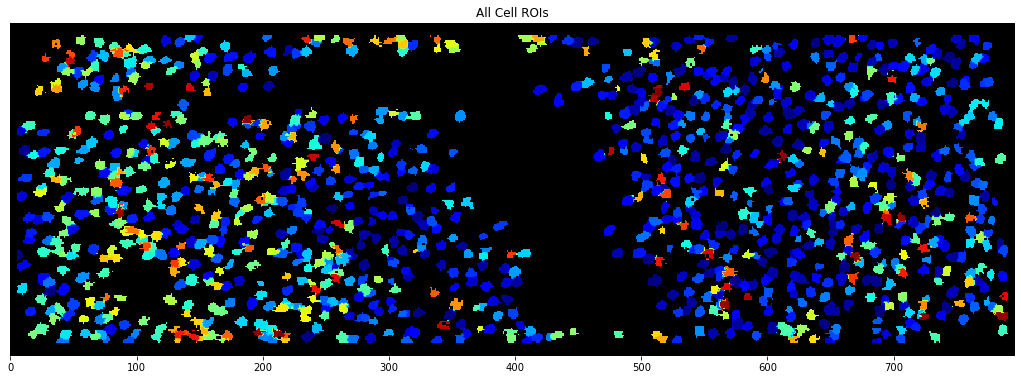

In [73]:
plt.imshow(np.nanmax(im[iscell], axis=0), cmap='jet')
plt.title("All Cell ROIs");

In [74]:
tt = np.nanmax(im[iscell], axis=0)
tt.shape

C:\Users\lan\anaconda3\envs\suite2p\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: All-NaN slice encountered
  """Entry point for launching an IPython kernel.


(264, 796)

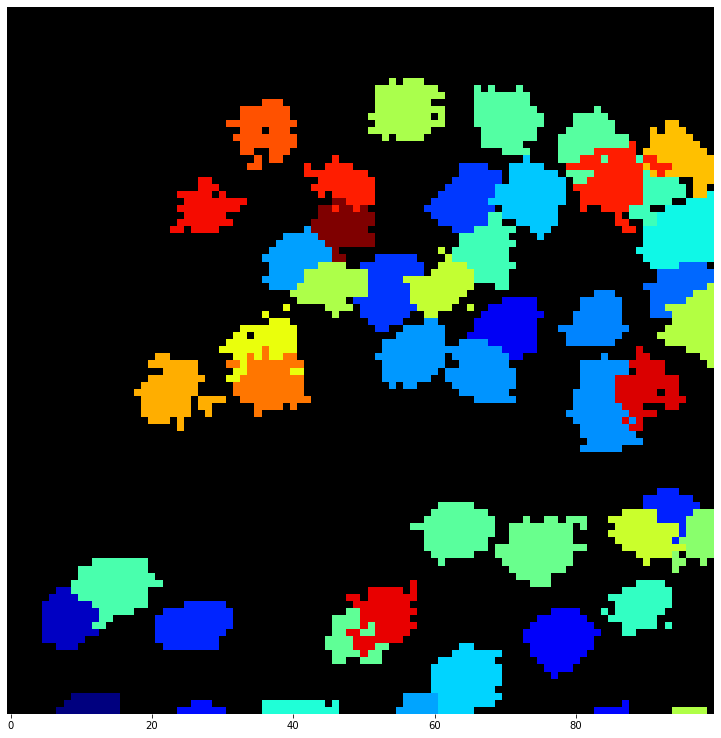

In [75]:
plt.imshow(tt[:100,:100], cmap='jet')

C:\Users\lan\anaconda3\envs\suite2p\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: All-NaN slice encountered
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'All Non-Cell ROIs')

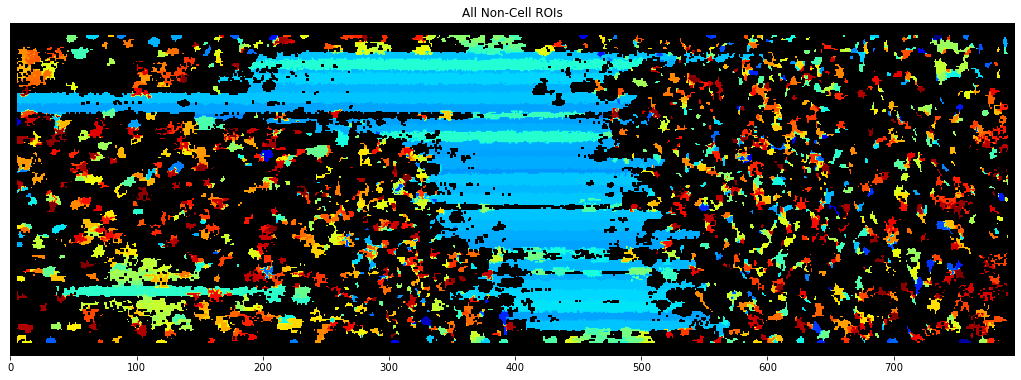

In [76]:
plt.imshow(np.nanmax(im[~iscell], axis=0, ), cmap='jet')
plt.title("All Non-Cell ROIs")

In [77]:
f_cells = np.load(Path(output_op['save_path']).joinpath('F.npy'))
f_neuropils = np.load(Path(output_op['save_path']).joinpath('Fneu.npy'))
spks = np.load(Path(output_op['save_path']).joinpath('spks.npy'))
f_cells.shape, f_neuropils.shape, spks.shape

((2685, 99999), (2685, 99999), (2685, 99999))

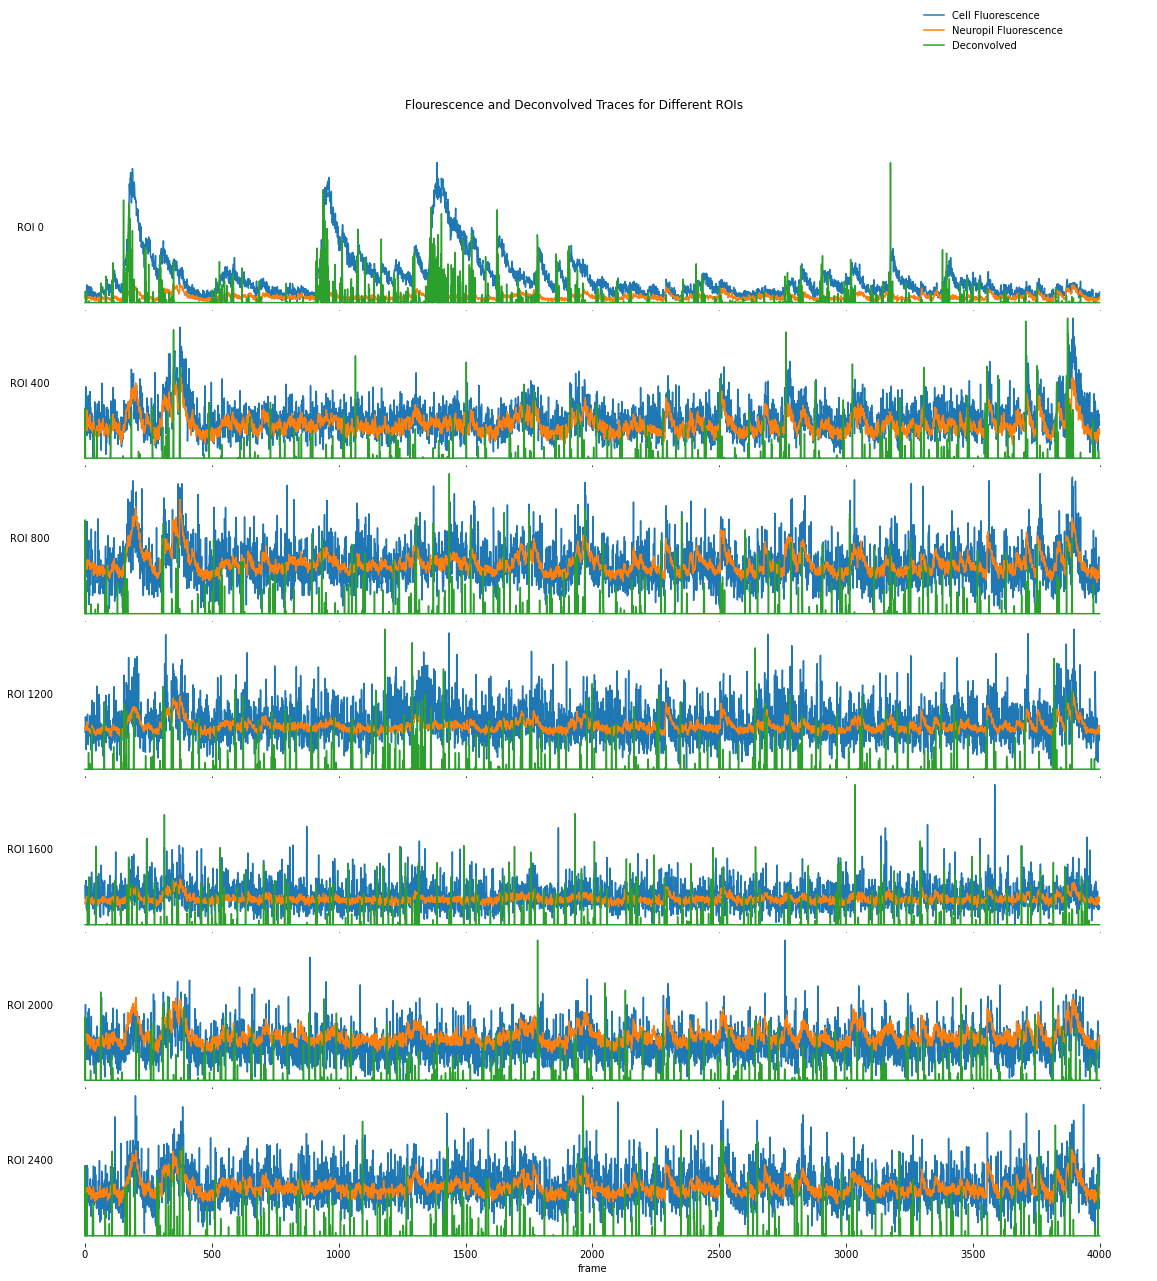

In [78]:
plt.figure(figsize=[20,20])
plt.suptitle("Flourescence and Deconvolved Traces for Different ROIs", y=0.92);
rois = np.arange(len(f_cells))[::400]

for i, roi in enumerate(rois):
    plt.subplot(len(rois), 1, i+1, )
    f = f_cells[roi]
    f_neu = f_neuropils[roi]
    sp = spks[roi]
    
    # cut f to first 4k frames to visualize better
    f = f[0:4000]
    f_neu = f_neu[0:4000]
    sp = sp[0:4000]
    
    # Adjust spks range to match range of fluroescence traces
    fmax = np.maximum(f.max(), f_neu.max())
    fmin = np.minimum(f.min(), f_neu.min())
    frange = fmax - fmin 
    sp /= sp.max()
    sp *= frange
    
    plt.plot(f, label="Cell Fluorescence")
    plt.plot(f_neu, label="Neuropil Fluorescence")
    plt.plot(sp + fmin, label="Deconvolved")
#     plt.xticks(np.arange(0, f_cells.shape[1], f_cells.shape[1]/10))
    plt.ylabel(f"ROI {roi}", rotation=0)
    plt.xlabel("frame")
    if i == 0:
        plt.legend(bbox_to_anchor=(0.93, 2))

In [45]:
whos

Variable             Type                       Data/Info
---------------------------------------------------------
Path                 type                       <class 'pathlib.Path'>
TemporaryDirectory   type                       <class 'tempfile.TemporaryDirectory'>
db                   dict                       n=4
default_ops          function                   <function default_ops at 0x00000042414F1828>
f                    ndarray                    4000: 4000 elems, type `float32`, 16000 bytes
f_cells              ndarray                    3773x99999: 377296227 elems, type `float32`, 1509184908 bytes (1439.2708854675293 Mb)
f_neu                ndarray                    4000: 4000 elems, type `float32`, 16000 bytes
f_neuropils          ndarray                    3773x99999: 377296227 elems, type `float32`, 1509184908 bytes (1439.2708854675293 Mb)
fmax                 float32                    1992.347
fmin                 float32                    801.5883
frange      

## Compare segmentation btw suite2p vs imCellEditInteractive in singleChannelTC_FS_LL.m

for some reason, ``cd`` command only works when put alone in a single code cell

In [79]:
pwd

'\\\\duhs-user-nc1.dhe.duke.edu\\dusom_glickfeldlab\\All_Staff\\home\\lan\\Data\\2P_images\\i1324\\200728\\003'

In [80]:
cd //duhs-user-nc1.dhe.duke.edu/dusom_glickfeldlab/All_Staff/home/lan/Analysis/2P/200728_i1324/200728_i1324_runs-003/

\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Analysis\2P\200728_i1324\200728_i1324_runs-003


In [81]:
from scipy.io import loadmat
segment_ref = loadmat('200728_i1324_runs-003_mask_cell_addfake.mat')

In [82]:
segment_ref['mask_cell'].shape

(264, 796)

In [83]:
segment_suite2p = np.nanmax(im[iscell], axis=0)
segment_suite2p.shape

C:\Users\lan\anaconda3\envs\suite2p\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: All-NaN slice encountered
  """Entry point for launching an IPython kernel.


(264, 796)

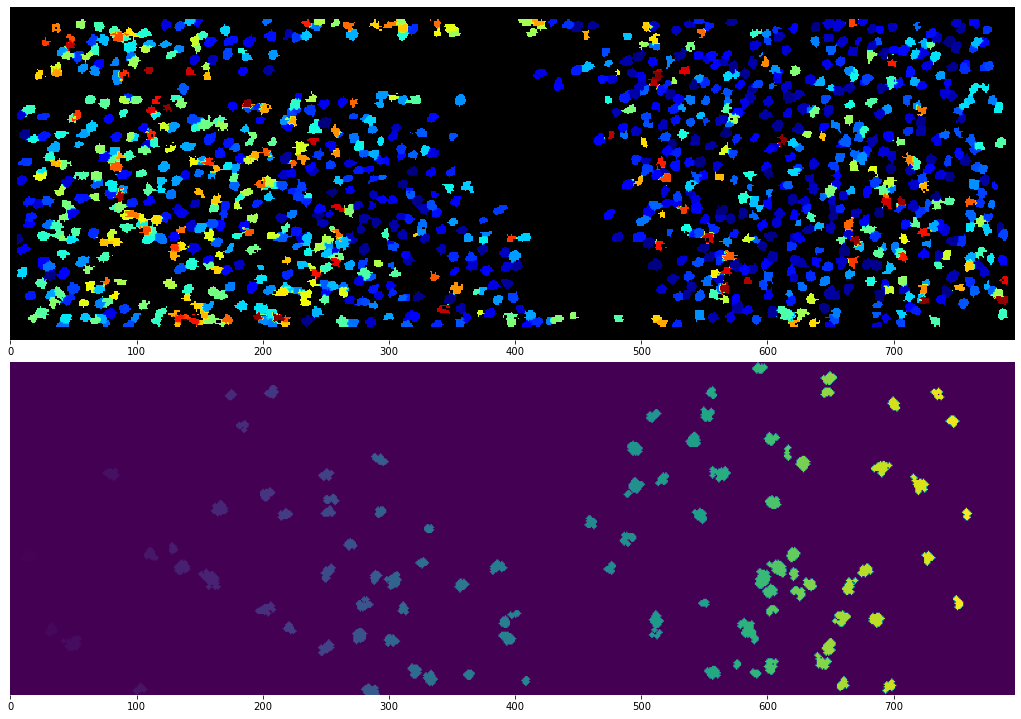

In [84]:
plt.subplot(2, 1, 1)
plt.imshow(segment_suite2p, cmap='jet')
plt.subplot(2, 1, 2)
plt.imshow(segment_ref['mask_cell'])

In [85]:
np.nan > 0

False

In [86]:
np.random.normal(0, 5, 10)

array([-9.83545924,  7.90096431,  5.58192741, -0.14427633,  7.12263163,
        4.29654884,  2.06169784,  1.20943412,  7.47276672,  2.42680575])

In [87]:
segment_suite2p_flat = segment_suite2p.copy()
# segment_suite2p_flat[segment_suite2p_flat>0] = 1 + np.random.normal(0, 500, len(segment_suite2p_flat[segment_suite2p_flat>0]))

segment_ref_flat = segment_ref['mask_cell'].copy()
segment_ref_flat[segment_ref_flat>0] = 1

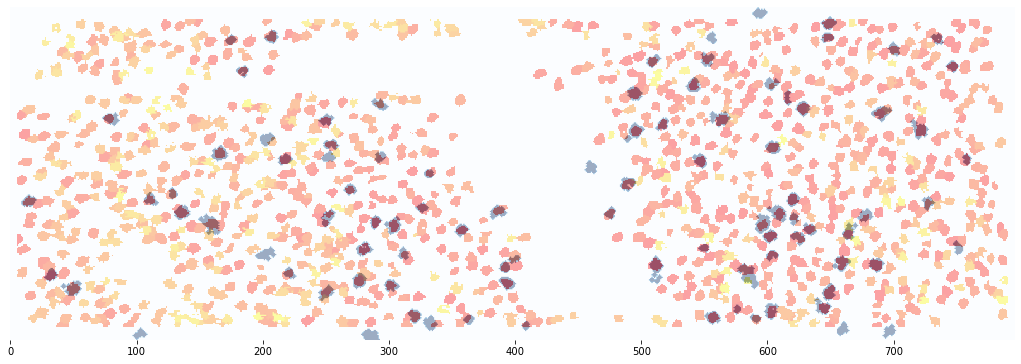

In [88]:
# im1 = plt.imshow(Z1, cmap=plt.cm.gray, interpolation='nearest', extent=extent)
im1 = plt.imshow(segment_suite2p_flat, cmap='autumn', alpha=0.6)
im2 = plt.imshow(segment_ref_flat, cmap='Blues', alpha=0.4)
plt.show()

In [ ]:
'''next step: 
more datasets (from v1 & lm & li?) to ensure overlap
confirm function by calculating correlation of fluo trace of overlapping "cell ROIs". negative control: shuffled data
'''